<a href="https://colab.research.google.com/github/lmmlima/ENV716_EnergyModeling_F2021/blob/main/Lab9/Lab9_MultiperiodLP_NetworkFlowI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 9 - More on Multiperiod Model and Network**


Learning outcomes for Lab 9:
* Show an alternative way to handle ordered sets;
* Start implementing network models - Transportation Networks

## Initializing 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

Installing Pyomo and glpk solver.

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

Importing pyomo and solver.

In [ ]:
from pyomo.environ import *
#Import solver
opt=SolverFactory('glpk')

## Alternative way of implementing Multiperiod example




Recall the example from lecture 14. A new company will manufacture 3 products by processing them in 2 different machines. Each product can be produced either 
inside the company or outside, at a higher cost. The inside production is constrained by the hours available at each machine, while outside production is unlimited. The company has sales contracts for the next 4 weeks. Production that exceeds the sales contracts can be kept in inventories at a cost. Find the optimal **production/purchase/inventory strategy**.





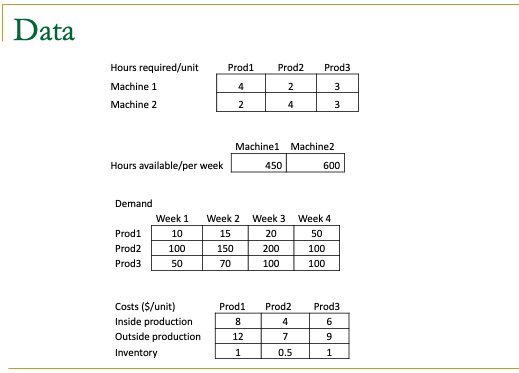

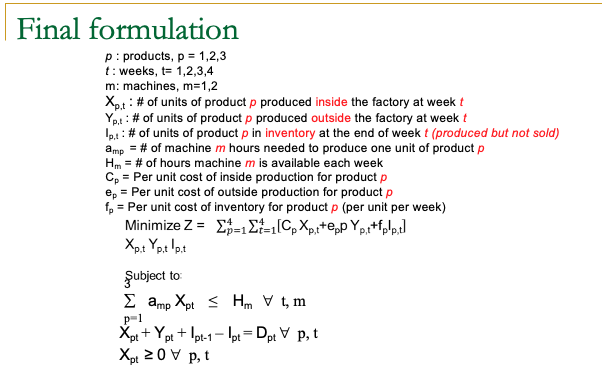

In [ ]:
#Creating model
model = ConcreteModel()

#Index decision variables by set
#defining sets
model.M=Set(initialize=['M1','M2'])  #set of machines
model.P=Set(initialize=['P1','P2','P3'])  #set of products
model.T=Set(initialize=['W1','W2','W3','W4'], ordered=True)   #set of weeks

In [ ]:
#Problem Parameters
model.a = Param(model.M,model.P,initialize={
    ('M1','P1'):4,
    ('M1','P2'):2,  
    ('M1','P3'):3, 
    ('M2','P1'):2,
    ('M2','P2'):4,
    ('M2','P3'):3})
model.H = Param(model.M,initialize={'M1':450,'M2':600})
model.D = Param(model.P,model.T,initialize={
    ('P1','W1'):10,
    ('P1','W2'):15,  
    ('P1','W3'):20, 
    ('P1','W4'):50,
    ('P2','W1'):100,
    ('P2','W2'):150,  
    ('P2','W3'):200, 
    ('P2','W4'):100,
    ('P3','W1'):50,
    ('P3','W2'):70,  
    ('P3','W3'):100, 
    ('P3','W4'):100})

model.c = Param(model.P,initialize={'P1':8,'P2':4,'P3':6})  #per unit cost of inside production
model.e = Param(model.P,initialize={'P1':12,'P2':7,'P3':9})  #per unit cost of outside production
model.f = Param(model.P,initialize={'P1':1,'P2':0.5,'P3':1})  #per unit cost of inventory


In [ ]:
#Adding dec var
model.X=Var(model.P,model.T,domain=NonNegativeReals)
model.Y=Var(model.P,model.T,domain=NonNegativeReals)
model.I=Var(model.P,model.T,domain=NonNegativeReals)

In [ ]:
#Adding constraints
def inv_bal(model,p,t):
    if(t=='W1'):
      return model.X[p,t] + model.Y[p,t] - model.I[p,t] == model.D[p,t]
    else:
      return model.X[p,t] + model.Y[p,t] + model.I[p,model.T.prev(t)] - model.I[p,t] == model.D[p,t]. #function prev() will access previous element and next() the next element
model.inventory = Constraint(model.P,model.T,rule=inv_bal)

def mach_hours(model,m,t):
    return sum(model.a[m,p]*model.X[p,t] for p in model.P) <= model.H[m]
model.mach = Constraint(model.M,model.T,rule=mach_hours)

In [ ]:
#Adding objective
model.cost=Objective( sense = minimize, 
                     expr = sum(sum( model.c[p]*model.X[p,t] + model.e[p]*model.Y[p,t] + model.f[p]*model.I[p,t] for p in model.P) for t in model.T))


In [ ]:
#Solve model
opt.solve(model)

#Print results
print("Cost =",model.cost())
print("Decision Variables")
for p in model.P:
  for t in model.T:
    print(model.X[p,t],model.X[p,t].value)
    print(model.Y[p,t],model.X[p,t].value)
    print(model.I[p,t],model.X[p,t].value)

Cost = 5726.25
Decision Variables
X[P1,W1] 10.0
Y[P1,W1] 10.0
I[P1,W1] 10.0
X[P1,W2] 15.0
Y[P1,W2] 15.0
I[P1,W2] 15.0
X[P1,W3] 20.0
Y[P1,W3] 20.0
I[P1,W3] 20.0
X[P1,W4] 50.0
Y[P1,W4] 50.0
I[P1,W4] 50.0
X[P2,W1] 107.5
Y[P2,W1] 107.5
I[P2,W1] 107.5
X[P2,W2] 90.0
Y[P2,W2] 90.0
I[P2,W2] 90.0
X[P2,W3] 95.0
Y[P2,W3] 95.0
I[P2,W3] 95.0
X[P2,W4] 100.0
Y[P2,W4] 100.0
I[P2,W4] 100.0
X[P3,W1] 50.0
Y[P3,W1] 50.0
I[P3,W1] 50.0
X[P3,W2] 70.0
Y[P3,W2] 70.0
I[P3,W2] 70.0
X[P3,W3] 60.0
Y[P3,W3] 60.0
I[P3,W3] 60.0
X[P3,W4] 16.6666666666667
Y[P3,W4] 16.6666666666667
I[P3,W4] 16.6666666666667


## Network Flows

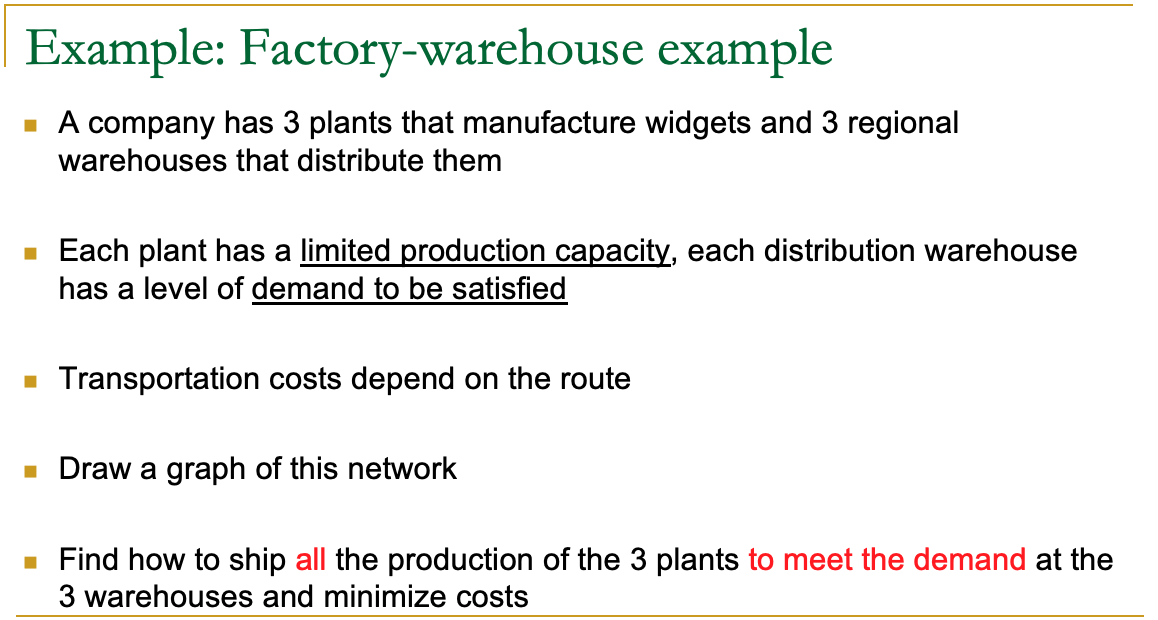

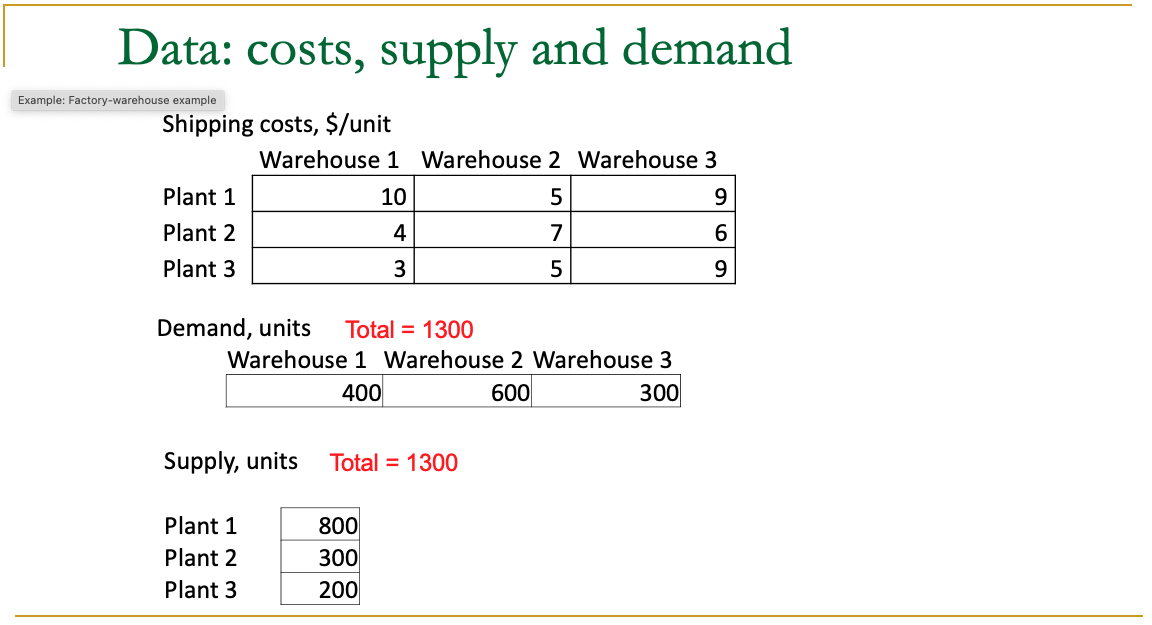

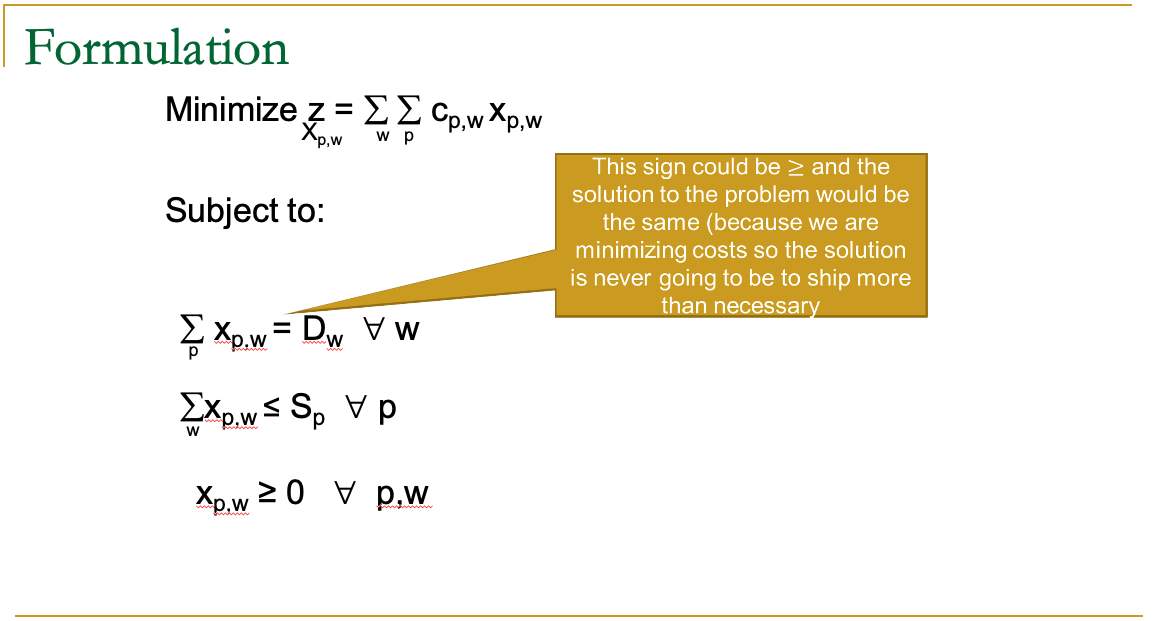

### Exercise 1: 
Debug the code below that solves the transportation problem above. The code below has **5 errors**. Find all of them to find the optimal solution to this model.

In [ ]:
#Creating model
model = ConcreteModel()

#Index decision variables by set
#defining sets
model.P=Set(initialize=['P1','P2','P3'])  #set of plants
model.W=Set(initialize=['W1','W2','W3'])   #set of warehouses

#defining parameters
model.cost=Param(model.P,model.W,initialize={
    ('P1','W1'):10,('P1','W2'):5,('P1','W3'):9,
    ('P2','W1'):4,('P2','W1'):7,('P2','W3'):6,
    ('P3','W1'):3,('P3','W2'):5,('P3','W3'):9})
model.supply=Param(model.P,initialize={'P1':800,'P2':300,'P3':200})
model.demand=Param(model.W,initialize={'W1':400,'W2':600,'W3':300})

#adding decision var
model.x=Var(model.P,model.W,domain=NonNegativeReals)

#adding objective
model.transcost=Objective(expr=sum(sum(model.cost[p,w]*x[p,w] for p in model.P) for w in model.W),sense=minimize)

#adding meet demand constraints
def meet_demand(model,w):
  return sum(model.x[p,w]) == model.demand[w]
model.meetdem=Constraint(model.W,rule=meet_demand)

#adding supply availability constraint
def avail_supply(model,p):
  return sum(model.x[p,w]  == model.supply[p] for w in model.W)
model.availsupply=Constraint(model.P,rule=avail_supply)

#Solving model
opt.solve(model)

#Print results
print("Total transportation cost =",model.transcost())
print("Decision Variables")
for p in model.P:
  for t in model.W:
    print(model.x[p,w],model.x[p,w].value)

### Exercise 2: 
Because supply is equal demand, both demand and supply availability constraints are satisfied with equality. But if supply is less than demand the model would be infeasible. To make the formulation more general we need to change the sign of the supply availability constraint. \\
Need to make sure we are not shipping more than we have on plants. \\
a) Copy and paste the above code. Change supply on P1 to 600 and re-run the code. What happened?\\
b) Change the supply constraing sign to <= . And now? \\
c) Change to P1 back to 800 and see we got the same solution from Exercise 1. 

### Exercise 3: 
Do we need to do the same with the meet demand constraint? If we had more supply than demand, the model would still be feasible. We don't need to worry about the equality on the meet demand. To better understand this concept: \\
a) Copy and paste the code from Exercise 2; \\
b) change the demand on warehouse 1 to 200; \\
c) Re-run the model. \\